In [25]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels)

# input image dimensions
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(glob.glob("data/*.npz")):
    file = np.load(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

In [67]:
# conv module
conv_in = Input(shape=input_shape)
## first layer
x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(conv_in)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
## second layer
x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
conv_out = Flatten()(x)

conv_model = Model(conv_in, conv_out)

# main network
main_input = Input(shape=input_shape)
x = conv_model(main_input)
x = Dense(64, activation='relu')(x)
main_output = Dropout(0.5)(x)

inputs = [main_input]
outputs = [main_output]

# hint network
num_hint = 5
for i in range(num_hint):
    hint_input = Input(shape=input_shape)
    x = conv_model(hint_input)
    hint_output = Dense(1, activation='relu')(x)
    inputs.append(hint_input)
    outputs.append(hint_output)

concatenated_neuron = Concatenate()(outputs)
out = Dense(num_classes, activation='softmax')(concatenated_neuron)
model = Model(inputs, out)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_68 (InputLayer)            (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_69 (InputLayer)            (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_70 (InputLayer)            (None, 48, 48, 1)     0                                            
____________________________________________________________________________________________________
input_71 (InputLayer)            (None, 48, 48, 1)     0                                            
___________________________________________________________________________________________

In [58]:
num_sample = 10
x_all = np.empty((0, 6, img_rows, img_cols))
y_all = np.empty(0)
for i in range(num_series):
    for j, img in enumerate(series_imgs[i]):
        num_imgs = len(series_imgs[i])
        label = series_labels[i][j]
        label_i = labels.index(label)
        xs = np.empty((0, 6, img_rows, img_cols))
        ys = np.empty(0)
        for k in range(num_sample):
            ids = np.random.randint(0, num_imgs, size=5)
            hints = series_imgs[i][ids]
            xs = np.r_[xs, [np.r_[[img], hints]]]
            ys = np.r_[ys, [label_i]]
        x_all = np.r_[x_all, xs]
        y_all = np.r_[y_all, ys]

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train_list = []
x_test_list = []
for i in range(1 + num_hint):
    x_train_list.append(x_train[:, i, :, :].reshape(x_train.shape[0], img_rows, img_cols, 1))
    x_test_list.append(x_test[:, i, :, :].reshape(x_test.shape[0], img_rows, img_cols, 1))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model.fit(x_train_list, y_train, batch_size=16, epochs=20, verbose=1, validation_data=(x_test_list, y_test))
score = model.evaluate(x_test_list, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (2943, 6, 48, 48)
2943 train samples
327 test samples
Train on 2943 samples, validate on 327 samples
Epoch 1/20
2943/2943 [==============================] - 11s - loss: 2.7122 - acc: 0.0669 - val_loss: 2.7089 - val_acc: 0.0459
Epoch 2/20
2943/2943 [==============================] - 10s - loss: 2.6407 - acc: 0.1050 - val_loss: 2.1507 - val_acc: 0.3700
Epoch 3/20
2943/2943 [==============================] - 10s - loss: 1.8677 - acc: 0.3547 - val_loss: 0.9236 - val_acc: 0.7401
Epoch 4/20
2943/2943 [==============================] - 10s - loss: 1.1960 - acc: 0.5647 - val_loss: 0.4490 - val_acc: 0.9327
Epoch 5/20
2943/2943 [==============================] - 10s - loss: 0.8405 - acc: 0.6972 - val_loss: 0.2300 - val_acc: 0.9480
Epoch 6/20
2943/2943 [==============================] - 10s - loss: 0.6522 - acc: 0.7587 - val_loss: 0.1540 - val_acc: 0.9908
Epoch 7/20
2943/2943 [==============================] - 10s - loss: 0.5571 - acc: 0.8002 - val_loss: 0.0719 - val_acc: 1.0000
Ep

In [70]:
pred_res = model.predict(x_test)

In [79]:
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
errors = np.where(res != ans)[0]
print(errors)

[ 6  4 12  0  8 23 17 21 10 18  7 14  7  6  0 20  5 22 20  4 24 11 28 14 28
 27  6  1  6 29  1 10  6 29 17 17  7  3 22  0 25  2 24  2  3 11  3  7  0 16
 28  9  1 18  8 19  5 16 14 17 23  9 29 24  1 19]
[ 6  4 12  0  8 23 17 21  5 18  7 14  7  6  0 20  5 22 20  4 25 11 28 14 28
 28  6  1  6 29  0 10  6 29 17 17  7  3 22  0 25  2 24  2  3 11  3  7  0 16
 28  9  1 18  8 19  5 16 14 17 23  9 29 25  0 19]
[ 8 20 25 30 63 64]


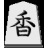

narikei


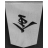

p
narigin


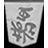

p
uma


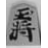

ou


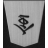

p
narigin


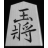

ou


In [83]:
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])